In [20]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

import matplotlib.pyplot as plt, numpy as np, xarray as xr, pandas as pd, datetime
import matplotlib as mpl
import matplotlib.patches as patches
import datetime, os, re, shutil

import pycubicspline

from sklearn.preprocessing import MinMaxScaler

from mpl_toolkits.basemap import Basemap

import matplotlib.image as mpimg

from glmtools.io.glm import GLMDataset

from squeemtools.Graphing import MakeBigGraph

import warnings
warnings.filterwarnings("ignore")

In [21]:
def cubic_spline_trackfile(file):
    '''Given a track file, calculate the cubic spline locations of the track file'''
    
    # Load the trackfile
    center = pd.read_csv(file,header=None,names=["Year","Month","Day","Hour","Lat","Long","Min_Pressure","Max_Winds","Unused"],low_memory=False,sep='\t')
    center = center.drop("Unused",axis=1)
    
    # Prep the data for spline
    temp = center.copy()
    temp = temp.drop_duplicates(subset='Long',keep='first') # That way there aren't 2 points in the same location
    
    # Make tuples of the data
    myx, myy = temp['Long'],temp['Lat']
    real = center['Long'],center['Lat']
    coords = myx,myy
    
    # Create datetime from dataframe
    temp['Date'] = (temp['Year'].astype('string')+'-'+temp['Month'].astype('string')+'-'+temp['Day'].astype('string')+'-'+temp['Hour'].astype('string')).apply(pd.to_datetime,format="%Y-%m-%d-%H")
    temp.drop(['Year','Month','Day','Hour'],axis=1,inplace=True)
    temp = temp.sort_values('Date')
    
    # Create the new rows for every 10 minutes
    first_date = temp.iloc[0].Date
    last_date = temp.iloc[-1].Date
    
    # Get the number of samples
    total_minutes = (last_date - first_date).total_seconds() // 60
    samples = int(total_minutes / 10) + 1
    
    # Calculate the cubic spline
    x,y,yaw,k,travel = pycubicspline.calc_2d_spline_interpolation(*coords,samples)
    
    # Plot the spline and the points
    plt.figure(figsize=(20,20))
    plt.plot(x,y,lw=5,c='blue',label='cubic spline')
    plt.scatter(*real,s=100,c='red',zorder=3,label='actual points')
    plt.legend()
    plt.show()
    
    # Create new list of dates
    dates = []
    for _ in range(len(x)):
        dates.append(first_date)
        first_date += datetime.timedelta(minutes = 10)
    
    # Create the new dataframe
    sample = pd.DataFrame(np.array([dates,x,y]).T,columns=[['Date','Long','Lat']])
    return sample

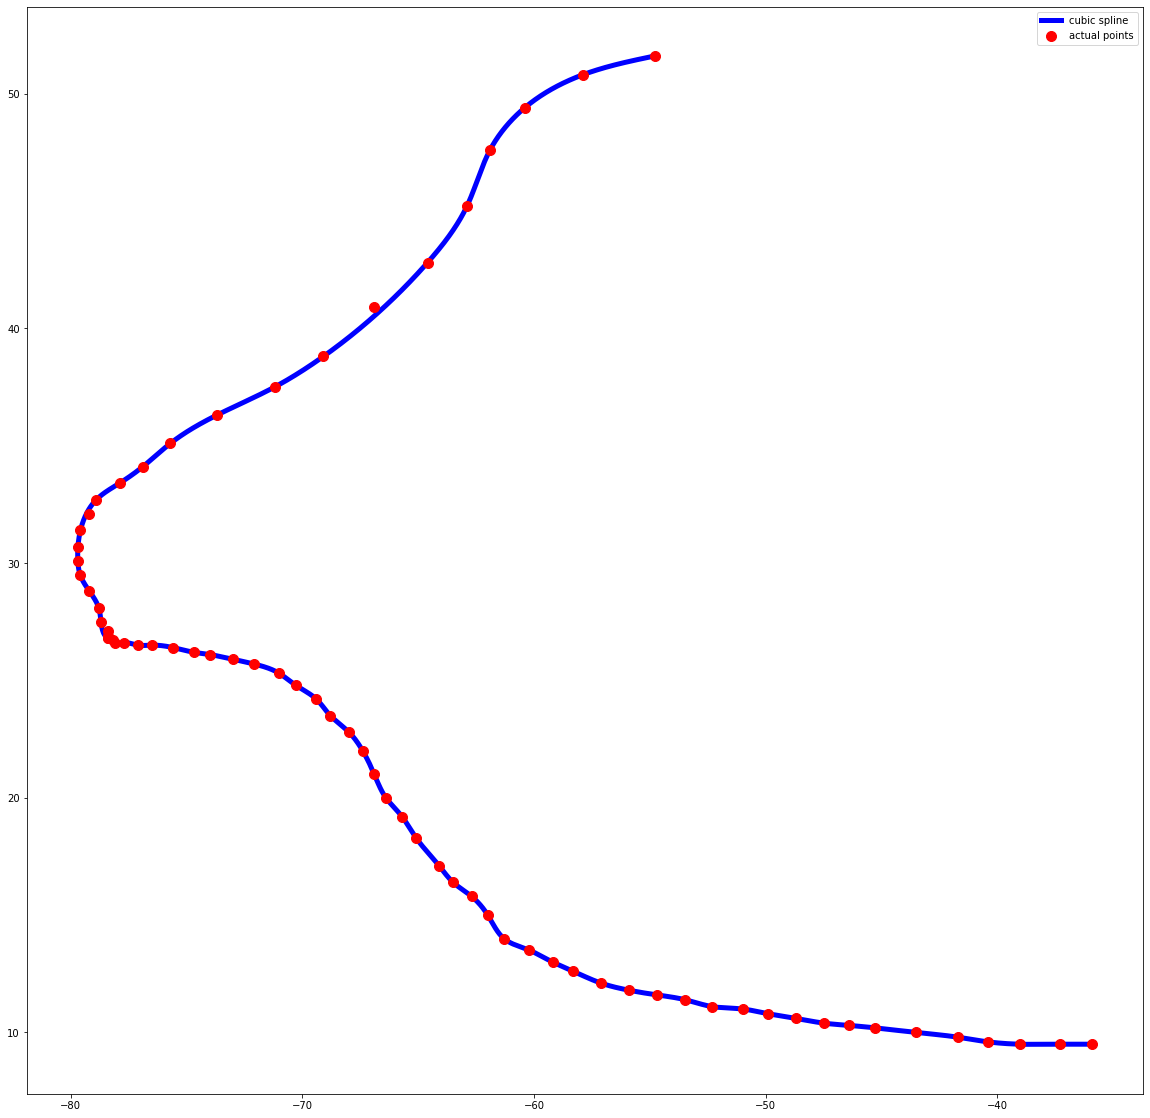

In [22]:
df = cubic_spline_trackfile('../Hurricane_Dorian/ATL_19_5_Dorian_Reduced_Trackfile.txt')

In [19]:
df

,Date,Long,Lat
0,2019-08-22 12:00:00,-35.9,9.5
1,2019-08-22 12:10:00,-35.9343,9.50011
2,2019-08-22 12:20:00,-35.9687,9.50023
3,2019-08-22 12:30:00,-36.003,9.50034
4,2019-08-22 12:40:00,-36.0374,9.50045
...,...,...,...
2516,2019-09-08 23:20:00,-54.9687,51.5653
2517,2019-09-08 23:30:00,-54.935,51.5723
2518,2019-09-08 23:40:00,-54.9012,51.5792
2519,2019-09-08 23:50:00,-54.8675,51.5861


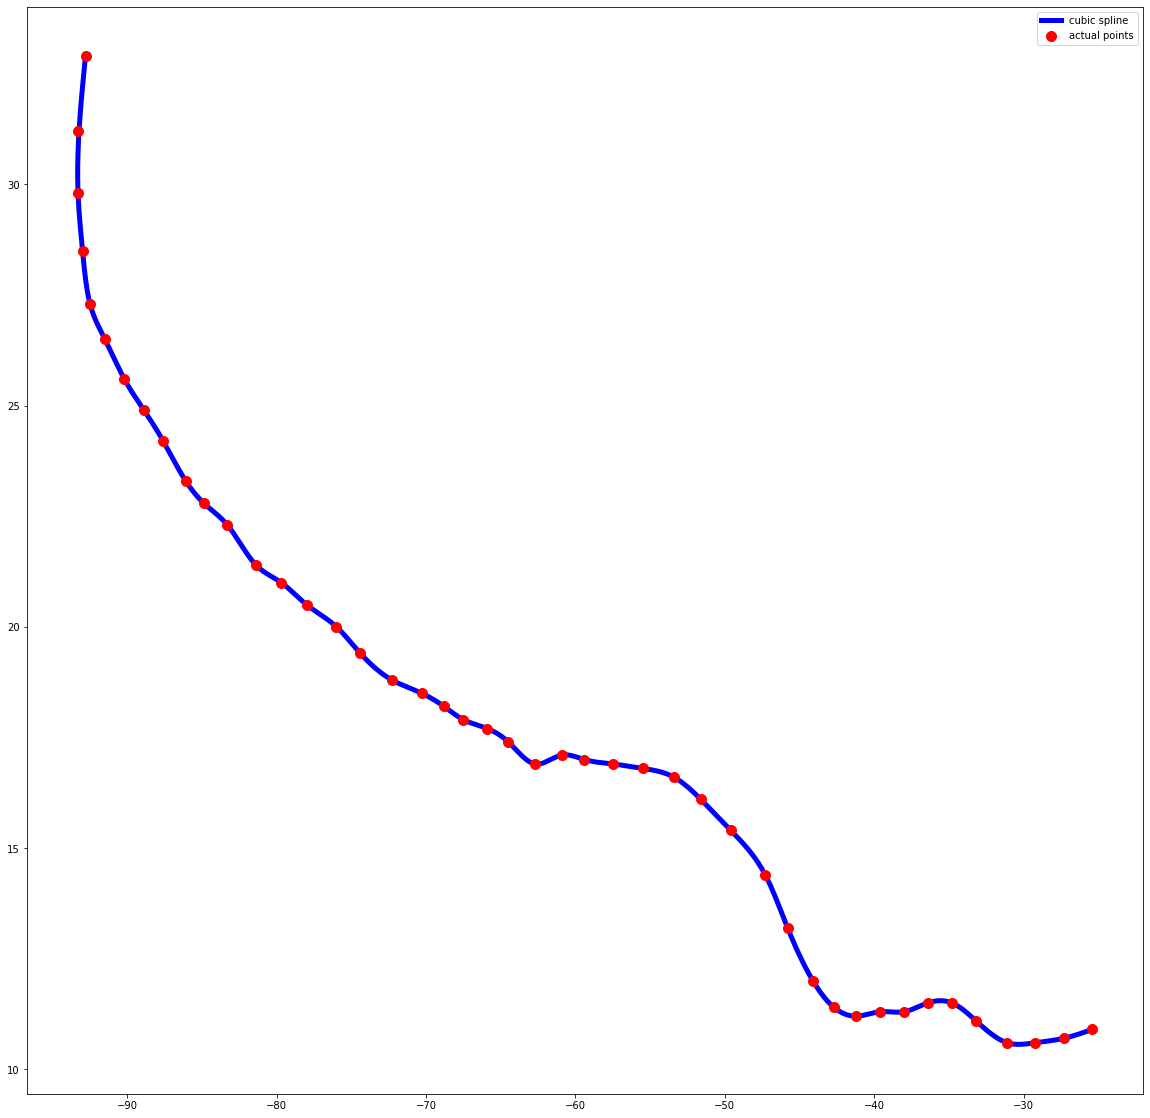

In [23]:
laura = cubic_spline_trackfile('../Hurricane_Laura_2020/ATL_20_13_Laura_Reduced_Trackfile.txt')

In [24]:
laura

,Date,Long,Lat
0,2020-08-16 18:00:00,-25.4,10.9
1,2020-08-16 18:10:00,-25.448,10.8943
2,2020-08-16 18:20:00,-25.4959,10.8885
3,2020-08-16 18:30:00,-25.5439,10.8828
4,2020-08-16 18:40:00,-25.5919,10.8771
...,...,...,...
1580,2020-08-27 17:20:00,-92.8708,32.66
1581,2020-08-27 17:30:00,-92.8567,32.708
1582,2020-08-27 17:40:00,-92.8426,32.756
1583,2020-08-27 17:50:00,-92.8284,32.804


In [25]:
laura.to_csv('../Hurricane_Laura_2020/ATL_20_13_Laura_Reduced_Trackfile_Spline.csv')